In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df['review']).toarray()
y = df['sentiment']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [3]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [4]:
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        self.v_bias = nn.Parameter(torch.zeros(visible_units))

    def forward(self, x):
        h_prob = torch.sigmoid(torch.matmul(x, self.W.t()) + self.h_bias)
        return h_prob

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


clf_orig = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)


clf_pca = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
clf_rbm = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)



In [ ]:
param_grid_orig = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [10]
}

grid_orig = GridSearchCV(MLPClassifier(random_state=42), param_grid_orig, cv=3, n_jobs=-1, verbose=2)
grid_orig.fit(X_train, y_train)

print("Best parameters (Original):", grid_orig.best_params_)


MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)

In [ ]:
param_grid_pca = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300]
}

grid_pca = GridSearchCV(MLPClassifier(random_state=42), param_grid_pca, cv=3, n_jobs=-1, verbose=2)
grid_pca.fit(X_train_pca, y_train)

print("Best parameters (PCA+MLP):", grid_pca.best_params_)


In [ ]:
param_grid_rbm = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300]
}

grid_rbm = GridSearchCV(MLPClassifier(random_state=42), param_grid_rbm, cv=3, n_jobs=-1, verbose=2)
grid_rbm.fit(X_train_rbm, y_train)

print("Best parameters (RBM+MLP):", grid_rbm.best_params_)


In [ ]:
y_pred_orig = grid_orig.predict(X_test)
y_pred_pca = grid_pca.predict(X_test_pca)
y_pred_rbm = grid_rbm.predict(X_test_rbm)

In [ ]:
print("🔹 Original Data - MLP (Tuned):")
print(classification_report(y_test, y_pred_orig))
print("🔹 PCA Data - MLP (Tuned):")
print(classification_report(y_test, y_pred_pca))
print("🔹 RBM Data - MLP (Tuned):")
print(classification_report(y_test, y_pred_rbm))

🔹 Original Data - Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4961
           1       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

🔹 PCA Data - Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4961
           1       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

🔹 RBM Data - MLP Classifier:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56      4961
           1       0.57      0.60      0.59      5039

    accuracy                           0.57     10000
   macro avg       0.57   

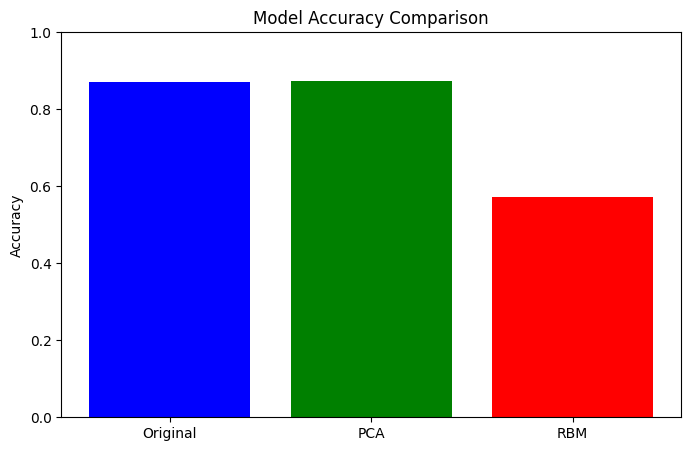

In [ ]:

acc_scores = [
    accuracy_score(y_test, y_pred_orig),
    accuracy_score(y_test, y_pred_pca),
    accuracy_score(y_test, y_pred_rbm)
]

plt.figure(figsize=(8, 5))
plt.bar(["Original", "PCA", "RBM"], acc_scores, color=["blue", "green", "red"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

In [ ]:

def plot_curves(y_test, y_pred, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, marker='.', label=f'PR Curve - {label}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({label})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC={auc_score:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({label})")
    plt.legend()

    plt.show()

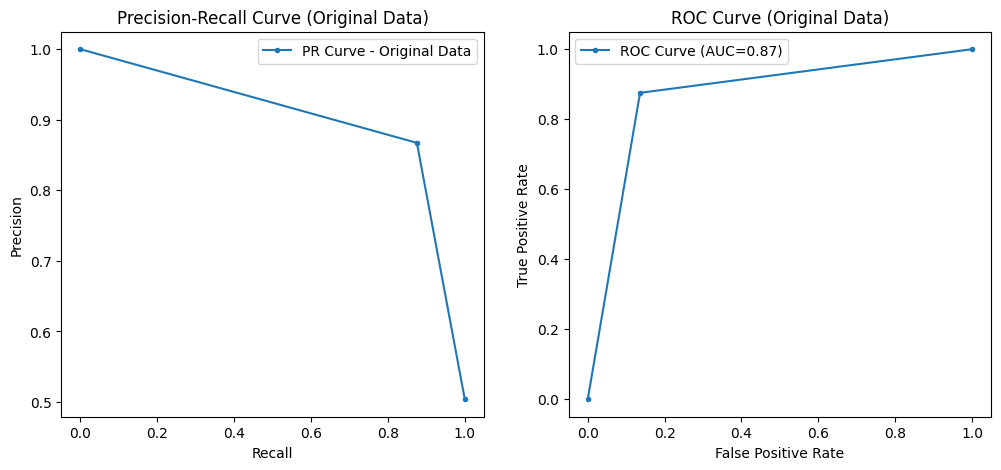

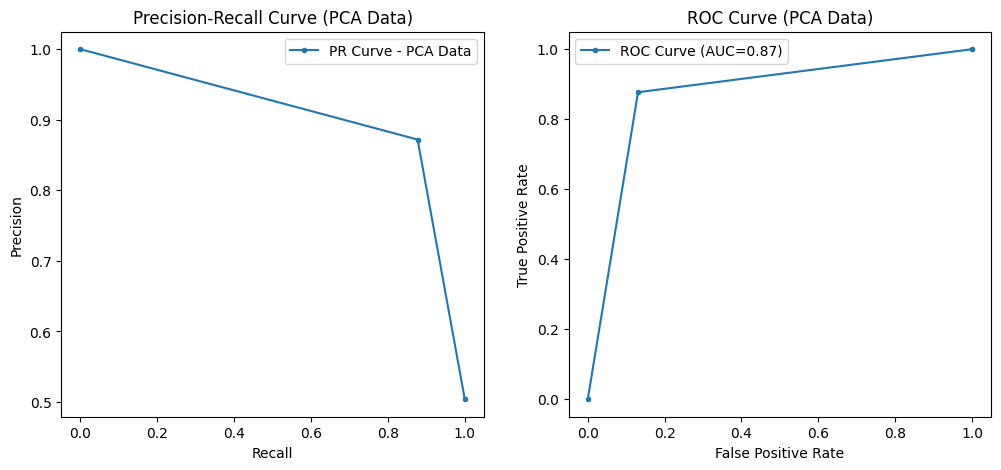

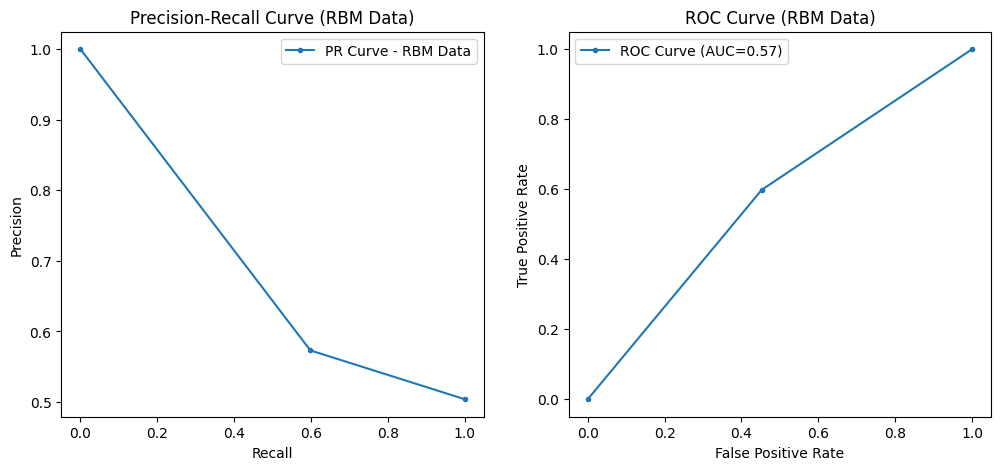

In [12]:

plot_curves(y_test, y_pred_orig, "Original Data")
plot_curves(y_test, y_pred_pca, "PCA Data")
plot_curves(y_test, y_pred_rbm, "RBM Data")

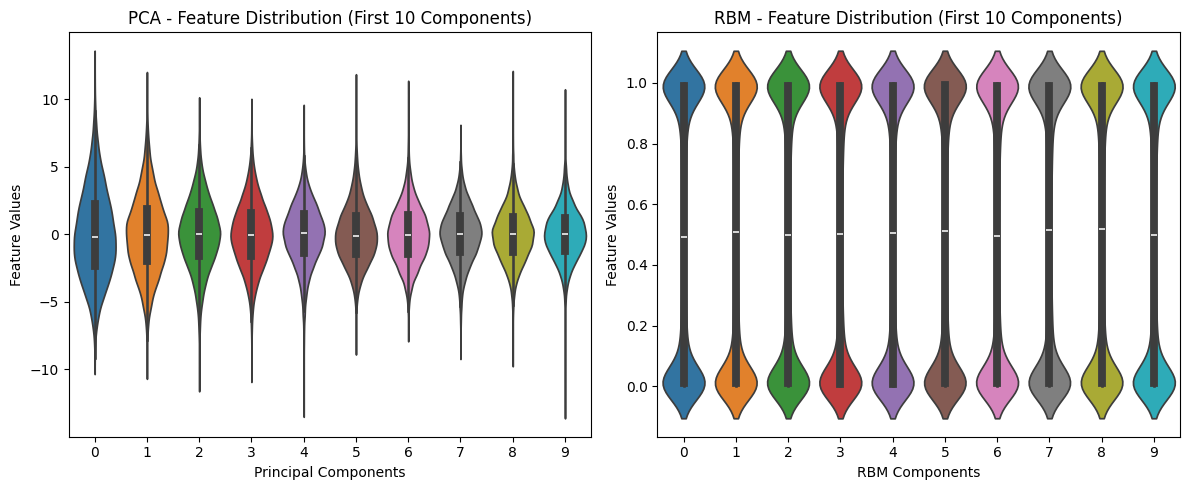

In [13]:
plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
X_sample_pca = pd.DataFrame(X_train_pca[:, :10])  
sns.violinplot(data=X_sample_pca) 
plt.title("PCA - Feature Distribution (First 10 Components)")
plt.xlabel("Principal Components")
plt.ylabel("Feature Values")

plt.subplot(1, 2, 2)
X_sample_rbm = pd.DataFrame(X_train_rbm[:, :10]) 
sns.violinplot(data=X_sample_rbm) 
plt.title("RBM - Feature Distribution (First 10 Components)")
plt.xlabel("RBM Components")
plt.ylabel("Feature Values")

plt.tight_layout()  
plt.show() 

In [ ]:
def plot_curves(y_true, y_pred, label):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, marker='.', label=f'PR Curve - {label}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({label})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC={auc_score:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({label})")
    plt.legend()

    plt.show()

# 🔹 Plotting Curves for Tuned Models
plot_curves(y_test, y_pred_orig, "Original Data")
plot_curves(y_test, y_pred_pca, "PCA Data")
plot_curves(y_test, y_pred_rbm, "RBM Data")

